This prototype replicates the approach adopted by Ciftci, Demir & Yin in their paper Synthetic Portrait Videos using Biological Signals. We use the facenet-pytorch package to build a rudimentary deepfake detector without training any models. It also demonstrates a method for (1) loading all video frames, (2) finding all faces, and (3) calculating face embeddings at over 30 frames per second (or greater than 1 video per 10 seconds).
The following steps are performed: 
1. Create pretrained facial detection (MTCNN) and recognition (Inception Resnet) models.
2. For each test video, calculate face feature vectors for ALL faces in each video.
3. Calculate the distance from each face to the centroid for its video.
4. Use these distances as your means of discrimination.
5. For (much) better results, finetune the resnet to the fake/real binary classification task instead.

In [24]:
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()
import seaborn as sns
# use the face detection pre-trained model from pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
#print wether I am using CPU or CUDA– used for Google Collab
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [26]:
sns.set()

In [7]:
#load the pre-trained model 
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()
# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

# Process Test Videos
After defining a few helper functions, this code loops through all videos and passes all frames from each through the face detector followed by facenet. Finally, we calculate the distance from the centroid to the extracted feature for each face

In [8]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

# Predict classes
The below weights were selected by following the same process as above for the train sample videos and then using a logistic regression model to fit to the labels. Note that, intuitively, this is not a very good approach as it does nothing to take into account the progression of feature vectors throughout a video, just combines them together using the weights below. This step is provided as a placeholder only; it should be replaced with a more thoughtful mapping from a sequence of feature vectors to a single prediction.

In [17]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=0.25)

# Get all test videos
filenames = glob.glob('/Users/asmaaaly/Downloads/test_videos/test_final/*.mp4')

X = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames), total=len(filenames)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            
            # Calculate embeddings
            X.append(process_faces(faces, resnet))

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

Frames per second (load+detect+embed):  0.375


In [18]:
bias = -0.2942
weight = 0.68235746

results = []
for filename, x_i in zip(filenames, X):
    if x_i is not None:
        prob = 1 / (1 + np.exp(-(bias + (weight * x_i).mean())))
    else:
        prob = 0.5
    results.append([os.path.basename(filename), prob])

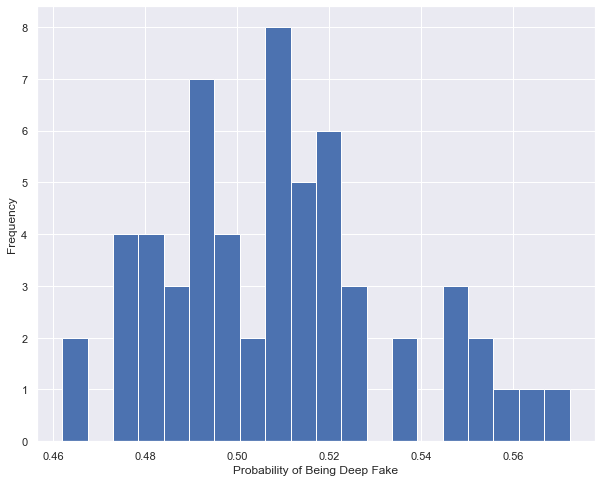

In [35]:
results = pd.DataFrame(results, columns=['filename', 'label'])
plt.figure(figsize=(10,8))
plt.hist(results.label, 20)
plt.xlabel("Probability of Being Deep Fake")
plt.ylabel("Frequency")

plt.show()

In [1]:
import os
from os.path import join
import argparse
import subprocess
import cv2
from tqdm import tqdm
import cv2  # still used to save images out
import os
import numpy as np
from decord import VideoReader
from decord import cpu, gpu

DATASET_PATHS = {
    'original': '/Volumes/MY PASSPORT/original_sequences/actors',
    'Deepfakes': '/Volumes/MY PASSPORT/manipulated_sequences/Deepfakes',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceSwap': 'manipulated_sequences/FaceSwap'
}
COMPRESSION = ['c0', 'c23', 'c40']

data_path = "/Volumes/MY PASSPORT/"

output_path = "/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/extracted"
def extract_frames_de(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=20):
    """
    Extract frames from a video using decord's VideoReader
    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """

    #video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    #frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible
    os.makedirs(frames_dir, exist_ok=True)

    print("using decord")
    #video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists
    # load the VideoReader
    vr = VideoReader(video_path, ctx=cpu(0))  # can set to cpu or gpu .. ctx=gpu(0)
                     
    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = len(vr)

    frames_list = list(range(start, end, every))
    saved_count = 0

    if every > 25 and len(frames_list) < 1000:  # this is faster for every > 25 frames and can fit in memory
        frames = vr.get_batch(frames_list).asnumpy()

        for index, frame in zip(frames_list, frames):  # lets loop through the frames until the end
            save_path = os.path.join(frames_dir, "{:010d}.jpg".format(index))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # save the extracted image
                saved_count += 1  # increment our counter by one

    else:  # this is faster for every <25 and consumes small memory
        for index in range(start, end):  # lets loop through the frames until the end
            frame = vr[index]  # read an image from the capture
            
            if index % every == 0:  # if this is a frame we want to write out based on the 'every' argument
                save_path = os.path.join(frames_dir, "{:04d}.png".format(index))  # create the save path
                if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                    cv2.imwrite(save_path, cv2.cvtColor(frame.asnumpy(), cv2.COLOR_RGB2BGR))  # save the extracted image
                    saved_count += 1  # increment our counter by one

    return saved_count  # and return the count of the images we saved



def extract_method_videos(data_path, dataset, compression):
    """Extracts all videos of a specified method and compression in the
    FaceForensics++ file structure"""
    videos_path = join(data_path, DATASET_PATHS[dataset], compression, 'videos')
    images_path = join(data_path, DATASET_PATHS[dataset], compression, 'images')
    for video in tqdm(os.listdir(videos_path)):
        image_folder = video.split('.')[0]
        #extract_frames(join(videos_path, video),
                       #join(images_path, image_folder))

        extract_frames_de(join(videos_path, video),
                       join(images_path, image_folder))
for dataset in DATASET_PATHS.keys():
    #extract_method_videos(data_path,'original','c23')


ModuleNotFoundError: No module named 'decord'

In [2]:
DATASET_PATHS = {
    'original': '/Volumes/MY PASSPORT/original_sequences/youtube',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceSwap': 'manipulated_sequences/FaceSwap'
}


In [5]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import cv2
import multiprocessing
import os
import sys


def print_progress(iteration, total, prefix='', suffix='', decimals=3, bar_length=100):
    """
    Call in a loop to create standard out progress bar

    :param iteration: current iteration
    :param total: total iterations
    :param prefix: prefix string
    :param suffix: suffix string
    :param decimals: positive number of decimals in percent complete
    :param bar_length: character length of bar
    :return: None
    """

    format_str = "{0:." + str(decimals) + "f}"  # format the % done number string
    percents = format_str.format(100 * (iteration / float(total)))  # calculate the % done
    filled_length = int(round(bar_length * iteration / float(total)))  # calculate the filled bar length
    bar = '#' * filled_length + '-' * (bar_length - filled_length)  # generate the bar string
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),  # write out the bar
    sys.stdout.flush()  # flush to stdout


def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using OpenCVs VideoCapture

    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists

    capture = cv2.VideoCapture(video_path)  # open the video using OpenCV

    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    capture.set(1, start)  # set the starting frame of the capture
    frame = start  # keep track of which frame we are up to, starting from start
    while_safety = 0  # a safety counter to ensure we don't enter an infinite while loop (hopefully we won't need it)
    saved_count = 0  # a count of how many frames we have saved

    while frame < end:  # lets loop through the frames until the end

        _, image = capture.read()  # read an image from the capture

        if while_safety > 500:  # break the while if our safety maxs out at 500
            break

        # sometimes OpenCV reads None's during a video, in which case we want to just skip
        if image is None:  # if we get a bad return flag or the image we read is None, lets not save
            while_safety += 1  # add 1 to our while safety, since we skip before incrementing our frame variable
            continue  # skip

        if frame % every == 0:  # if this is a frame we want to write out based on the 'every' argument
            while_safety = 0  # reset the safety count
            save_path = os.path.join(frames_dir, "{:010d}.jpg".format(frame))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, image)  # save the extracted image
                saved_count += 1  # increment our counter by one

        frame += 1  # increment our frame count

    capture.release()  # after the while has finished close the capture

    return saved_count  # and return the count of the images we saved


def video_to_frames(video_path, frames_dir, overwrite=True, every=1, chunk_size=1000):
    """
    Extracts the frames from a video using multiprocessing

    :param video_path: path to the video
    :param frames_dir: directory to save the frames
    :param overwrite: overwrite frames if they exist?
    :param every: extract every this many frames
    :param chunk_size: how many frames to split into chunks (one chunk per cpu core process)
    :return: path to the directory where the frames were saved, or None if fails
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    # make directory to save frames, its a sub dir in the frames_dir with the video name
    os.makedirs(os.path.join(frames_dir, video_filename), exist_ok=True)

    capture = cv2.VideoCapture(video_path)  # load the video
    total = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))  # get its total frame count
    capture.release()  # release the capture straight away

    if total < 1:  # if video has no frames, might be and opencv error
        print("Video has no frames. Check your OpenCV + ffmpeg installation")
        return None  # return None

    frame_chunks = [[i, i+chunk_size] for i in range(0, total, chunk_size)]  # split the frames into chunk lists
    frame_chunks[-1][-1] = min(frame_chunks[-1][-1], total-1)  # make sure last chunk has correct end frame, also handles case chunk_size < total

    prefix_str = "Extracting frames from {}".format(video_filename)  # a prefix string to be printed in progress bar

    # execute across multiple cpu cores to speed up processing, get the count automatically
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:

        futures = [executor.submit(extract_frames, video_path, frames_dir, overwrite, f[0], f[1], every)
                   for f in frame_chunks]  
    return os.path.join(frames_dir, video_filename)  # when done return the directory containing the frames


for dataset in DATASET_PATHS.keys():
    videos_path = join(DATASET_PATHS['original'], 'c40', 'videos')
    images_path = join(DATASET_PATHS['original'], 'c40', 'images')
    for video in tqdm(os.listdir(videos_path)):
        image_folder = video.split('.')[0]
        video_to_frames(video_path= join(videos_path, video), frames_dir= join(images_path, image_folder), overwrite=False, every=5, chunk_size=1000)

01 [51:20<33:50,  6.11s/it]
100%|██████████| 1001/1001 [1:19:21<00:00,  4.76s/it]

  0%|          | 0/1001 [00:00<?, ?it/s]Process ForkProcess-24021:
Process ForkProcess-24019:
Process ForkProcess-24023:
Process ForkProcess-24020:
Process ForkProcess-24018:
Process ForkProcess-24024:
Process ForkProcess-24022:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/asmaaaly/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/asmaaaly/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/asmaaaly/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/asmaaaly/opt/anaconda3/lib/python3.7/multiprocessing/process.py", li

KeyboardInterrupt: 